## 1. Install and Import Dependencies

In [ ]:
%pip install ultralytics pandas opencv-python matplotlib seaborn Pillow

In [ ]:
import os
import random
import pandas as pd
from PIL import Image
import cv2
from ultralytics import YOLO
from IPython.display import Video
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

sns.set(style='darkgrid')
sns.set(rc={'axes.facecolor': '#eae8fa'}, style='darkgrid')

In [ ]:
import zipfile
import yaml

if os.path.exists('car.zip'):
    print("Unzipping car.zip...")
    with zipfile.ZipFile('car.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Dataset unzipped.")
else:
    print("'car.zip' not found. Please upload it to the Colab runtime.")

# Define dataset root
dataset_root = 'car'

# 2. Create a data.yaml file compatible with Colab paths
data_yaml_content = {
    'train': f'{os.path.abspath(dataset_root)}/train/images',
    'val': f'{os.path.abspath(dataset_root)}/valid/images',
    'test': f'{os.path.abspath(dataset_root)}/test/images',
    'nc': 15,
    'names': ['Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 'Speed Limit 110', 'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 80', 'Speed Limit 90', 'Stop']
}

with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml_content, f, default_flow_style=None)

print("data.yaml created with Colab paths.")

Unzipping car.zip...
Dataset unzipped.
data.yaml created with Colab paths.


## 2. Visualize Dataset Samples

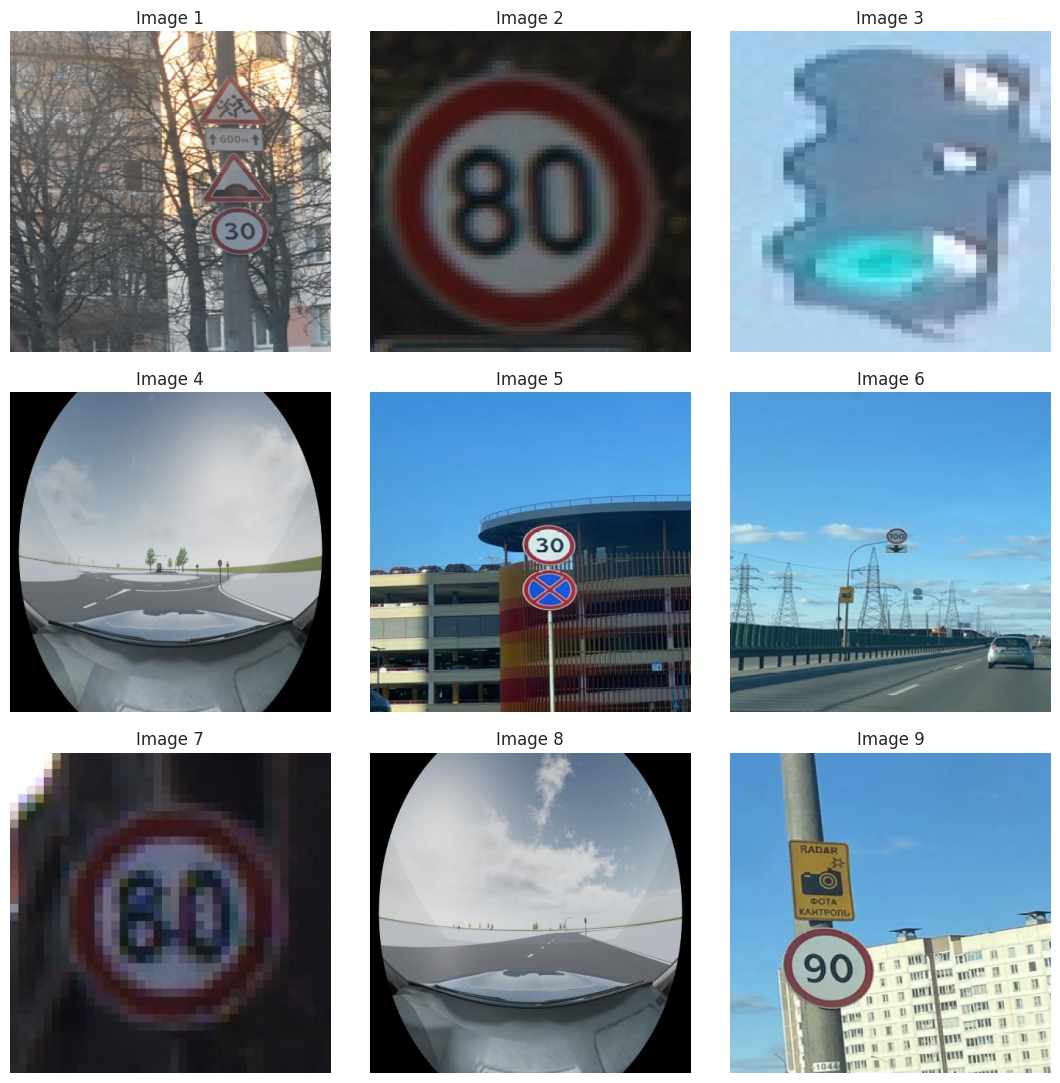

In [ ]:
# Define path to training images
train_images_dir = os.path.join(dataset_root, 'train', 'images')

if os.path.exists(train_images_dir):
    image_files = os.listdir(train_images_dir)
    num_samples = 9

    # Randomly select num_samples images
    if len(image_files) >= num_samples:
        rand_images = random.sample(image_files, num_samples)

        fig, axes = plt.subplots(3, 3, figsize=(11, 11))

        for i in range(num_samples):
            image_file = rand_images[i]
            image_path = os.path.join(train_images_dir, image_file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            ax = axes[i // 3, i % 3]
            ax.imshow(image)
            ax.set_title(f'Image {i+1}')
            ax.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Not enough images in {train_images_dir} to display {num_samples} samples.")
else:
    print(f"Directory not found: {train_images_dir}")

## 3. Check Image Dimensions
Read a sample image to determine its height, width, and channel count.

In [ ]:
if os.path.exists(train_images_dir) and len(image_files) > 0:
    sample_image_path = os.path.join(train_images_dir, image_files[0])
    image = cv2.imread(sample_image_path)
    h, w, c = image.shape
    print(f"The image has dimensions {w}x{h} and {c} channels.")
else:
    print("No images found to check dimensions.")

The image has dimensions 416x416 and 3 channels.


## 4. Initialize Base YOLO11n Model

In [ ]:
# Load a pretrained YOLOv11n model
model = YOLO("yolo11n.pt")

## 5. Train Custom Model

In [ ]:
# Define path
data_yaml_path = 'data.yaml'

# Train the model
results = model.train(data=data_yaml_path, epochs=30, batch=-1, optimizer='auto', imgsz=640)

Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

source_path = 'runs/detect/train3/weights/best.pt'

dest_path = '/content/drive/MyDrive/yolo_car_sign_detection.pt'

try:
    shutil.copy(source_path, dest_path)
    print(f"Success! Saved to: {dest_path}")
except FileNotFoundError:
    print("Could not find the source file.")

Success! Saved to: /content/drive/MyDrive/yolo_car_sign_detection.pt


## 6. Visualize Training Metrics
Load the `results.csv` file to analyze performance.

Loading results from: runs/detect/train3/results.csv


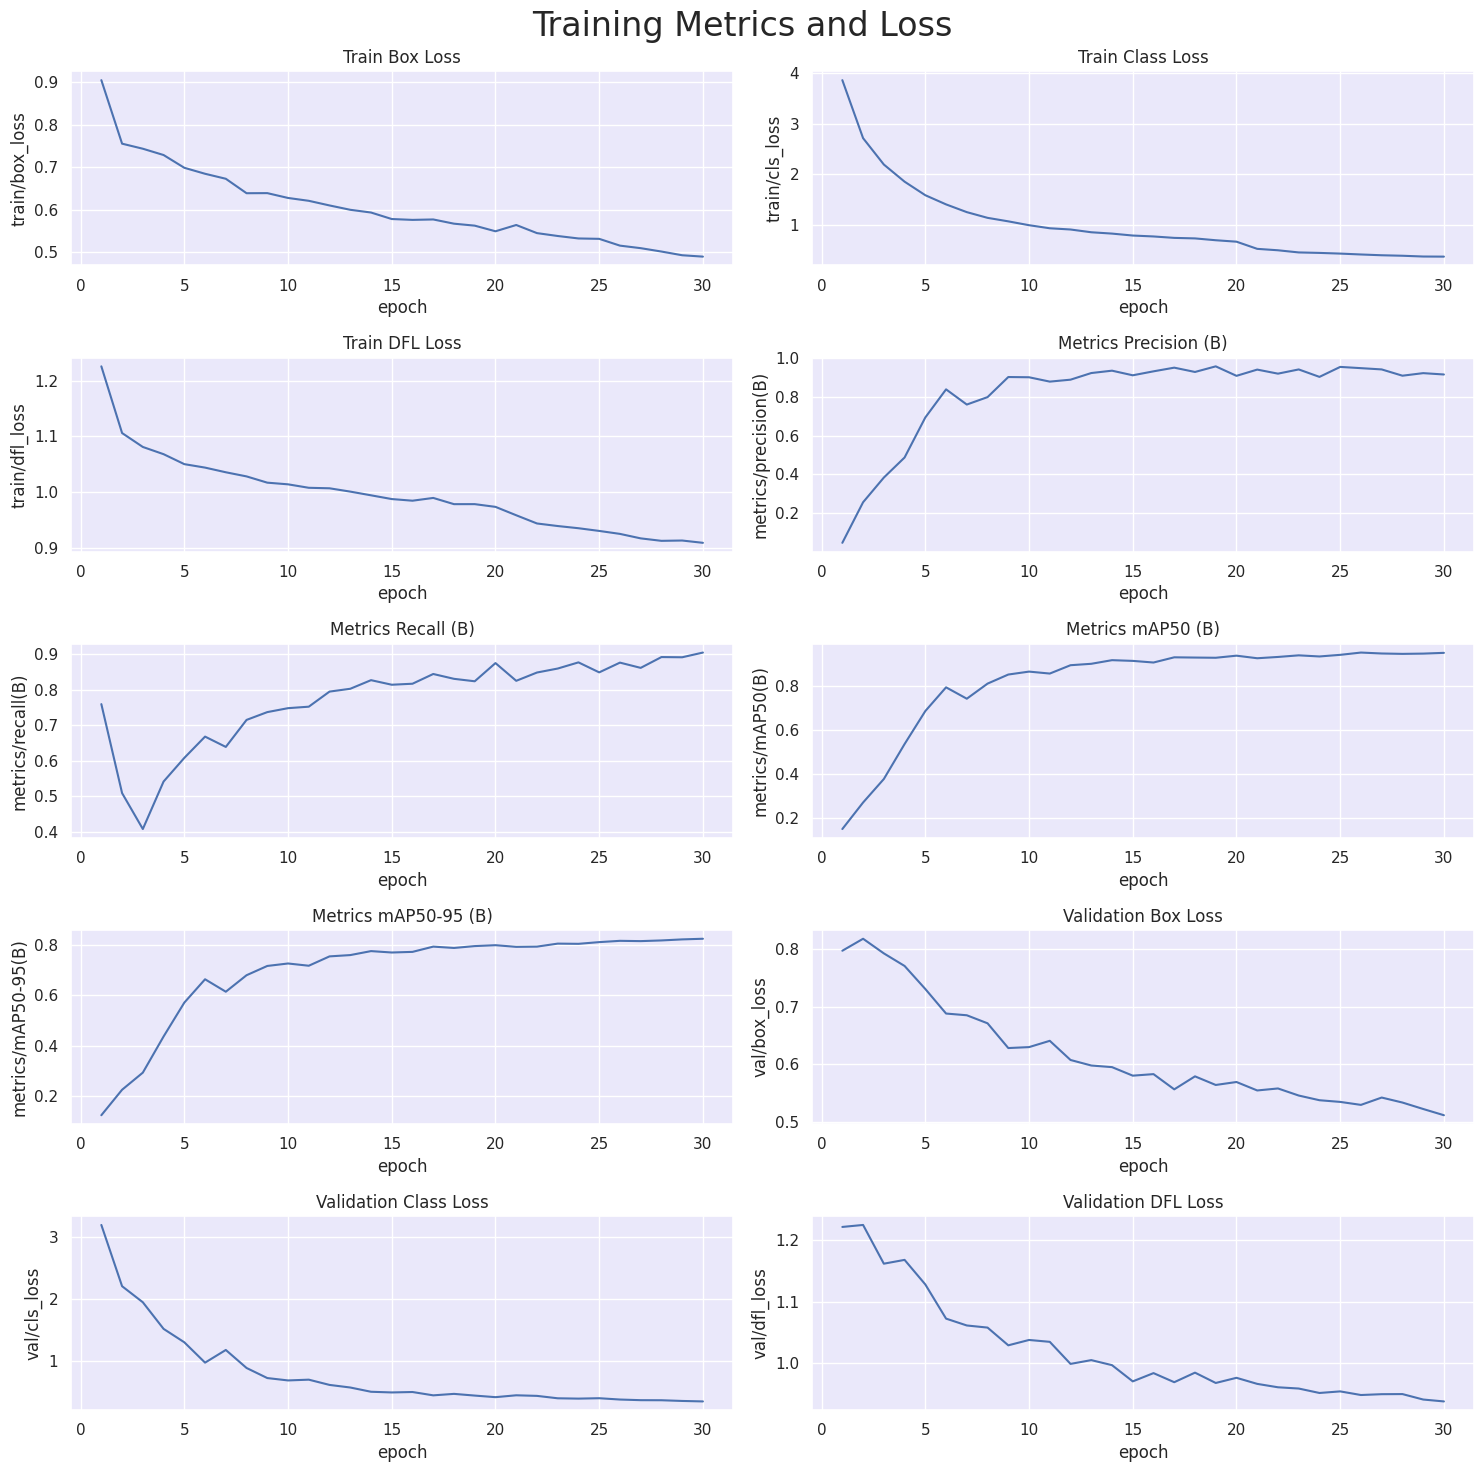

In [ ]:
runs_dir = 'runs/detect'
if os.path.exists(runs_dir):
    dirs = [d for d in os.listdir(runs_dir) if os.path.isdir(os.path.join(runs_dir, d))]
    dirs.sort(key=lambda x: os.path.getmtime(os.path.join(runs_dir, x)), reverse=True)

    if dirs:
        latest_run = dirs[0]
        results_path = os.path.join(runs_dir, latest_run, 'results.csv')

        if os.path.exists(results_path):
            print(f"Loading results from: {results_path}")
            results_df = pd.read_csv(results_path)
            results_df.columns = results_df.columns.str.strip()

            # Plot metrics
            fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

            # Helper
            def safe_plot(x, y, data, ax, title):
                if y in data.columns:
                    sns.lineplot(x=x, y=y, data=data, ax=ax)
                    ax.set_title(title)
                else:
                    ax.text(0.5, 0.5, f'{y} not found', ha='center')

            safe_plot('epoch', 'train/box_loss', results_df, axs[0,0], 'Train Box Loss')
            safe_plot('epoch', 'train/cls_loss', results_df, axs[0,1], 'Train Class Loss')
            safe_plot('epoch', 'train/dfl_loss', results_df, axs[1,0], 'Train DFL Loss')
            safe_plot('epoch', 'metrics/precision(B)', results_df, axs[1,1], 'Metrics Precision (B)')
            safe_plot('epoch', 'metrics/recall(B)', results_df, axs[2,0], 'Metrics Recall (B)')
            safe_plot('epoch', 'metrics/mAP50(B)', results_df, axs[2,1], 'Metrics mAP50 (B)')
            safe_plot('epoch', 'metrics/mAP50-95(B)', results_df, axs[3,0], 'Metrics mAP50-95 (B)')
            safe_plot('epoch', 'val/box_loss', results_df, axs[3,1], 'Validation Box Loss')
            safe_plot('epoch', 'val/cls_loss', results_df, axs[4,0], 'Validation Class Loss')
            safe_plot('epoch', 'val/dfl_loss', results_df, axs[4,1], 'Validation DFL Loss')

            plt.suptitle('Training Metrics and Loss', fontsize=24)
            plt.subplots_adjust(top=0.9)
            plt.tight_layout()
            plt.show()
        else:
            print(f"results.csv not found in {latest_run}")
    else:
        print("No training runs found.")
else:
    print("runs/detect directory not found. Did you run the training?")

## 7. Validate Model Performance
Load the best weights from the training run and execute `model.val()` on the validation split.

In [ ]:
# Load the best model from the latest run
if os.path.exists(runs_dir) and dirs:
    best_weights_path = os.path.join(runs_dir, latest_run, 'weights', 'best.pt')
    if os.path.exists(best_weights_path):
        print(f"Loading best model from: {best_weights_path}")
        best_model = YOLO(best_weights_path)

        # Validate
        metrics = best_model.val(data=data_yaml_path, split='val')

        print("precision(B): ", metrics.results_dict.get("metrics/precision(B)"))
        print("metrics/recall(B): ", metrics.results_dict.get("metrics/recall(B)"))
        print("metrics/mAP50(B): ", metrics.results_dict.get("metrics/mAP50(B)"))
        print("metrics/mAP50-95(B): ", metrics.results_dict.get("metrics/mAP50-95(B)"))
    else:
        print("best.pt not found.")
else:
    print("No training runs found.")

Loading best model from: runs/detect/train3/weights/best.pt
Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,585,077 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 439.4±196.7 MB/s, size: 11.9 KB)
val: Scanning /content/car/valid/labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 801/801 1.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 51/51 5.7it/s 8.9s
                   all        801        944      0.915      0.906      0.951      0.827
           Green Light         87        122      0.869       0.76      0.839      0.508
             Red Light         74        108      0.858      0.783       0.84       0.53
       Speed Limit 100         52         52      0.974      0.942      0.982      0.899
       Speed Limit 110         17         17      0.677      0.862       0.91    

## 8. Run Inference on Test Images
Perform object detection on unseen test images using the trained model.


image 1/1 /content/car/test/images/000753_jpg.rf.23d05489386c3399c5d26ac779015d26.jpg: 640x640 1 Speed Limit 90, 15.6ms
Speed: 5.7ms preprocess, 15.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/car/test/images/000599_jpg.rf.87f4886233a457df94743a34ee410218.jpg: 640x640 1 Speed Limit 80, 12.0ms
Speed: 5.4ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/car/test/images/FisheyeCamera_1_00922_png.rf.408835a278b9c700eb1a2f358ca58d07.jpg: 640x640 (no detections), 13.4ms
Speed: 4.4ms preprocess, 13.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/car/test/images/00000_00005_00003_png.rf.df858754a637fecb106924e9bc47a832.jpg: 640x640 1 Speed Limit 20, 15.3ms
Speed: 5.4ms preprocess, 15.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/car/test/images/000790_jpg.rf.ddb1d679830f7cafbcbec2013a6ff2fc.jpg: 640x640 1 Speed

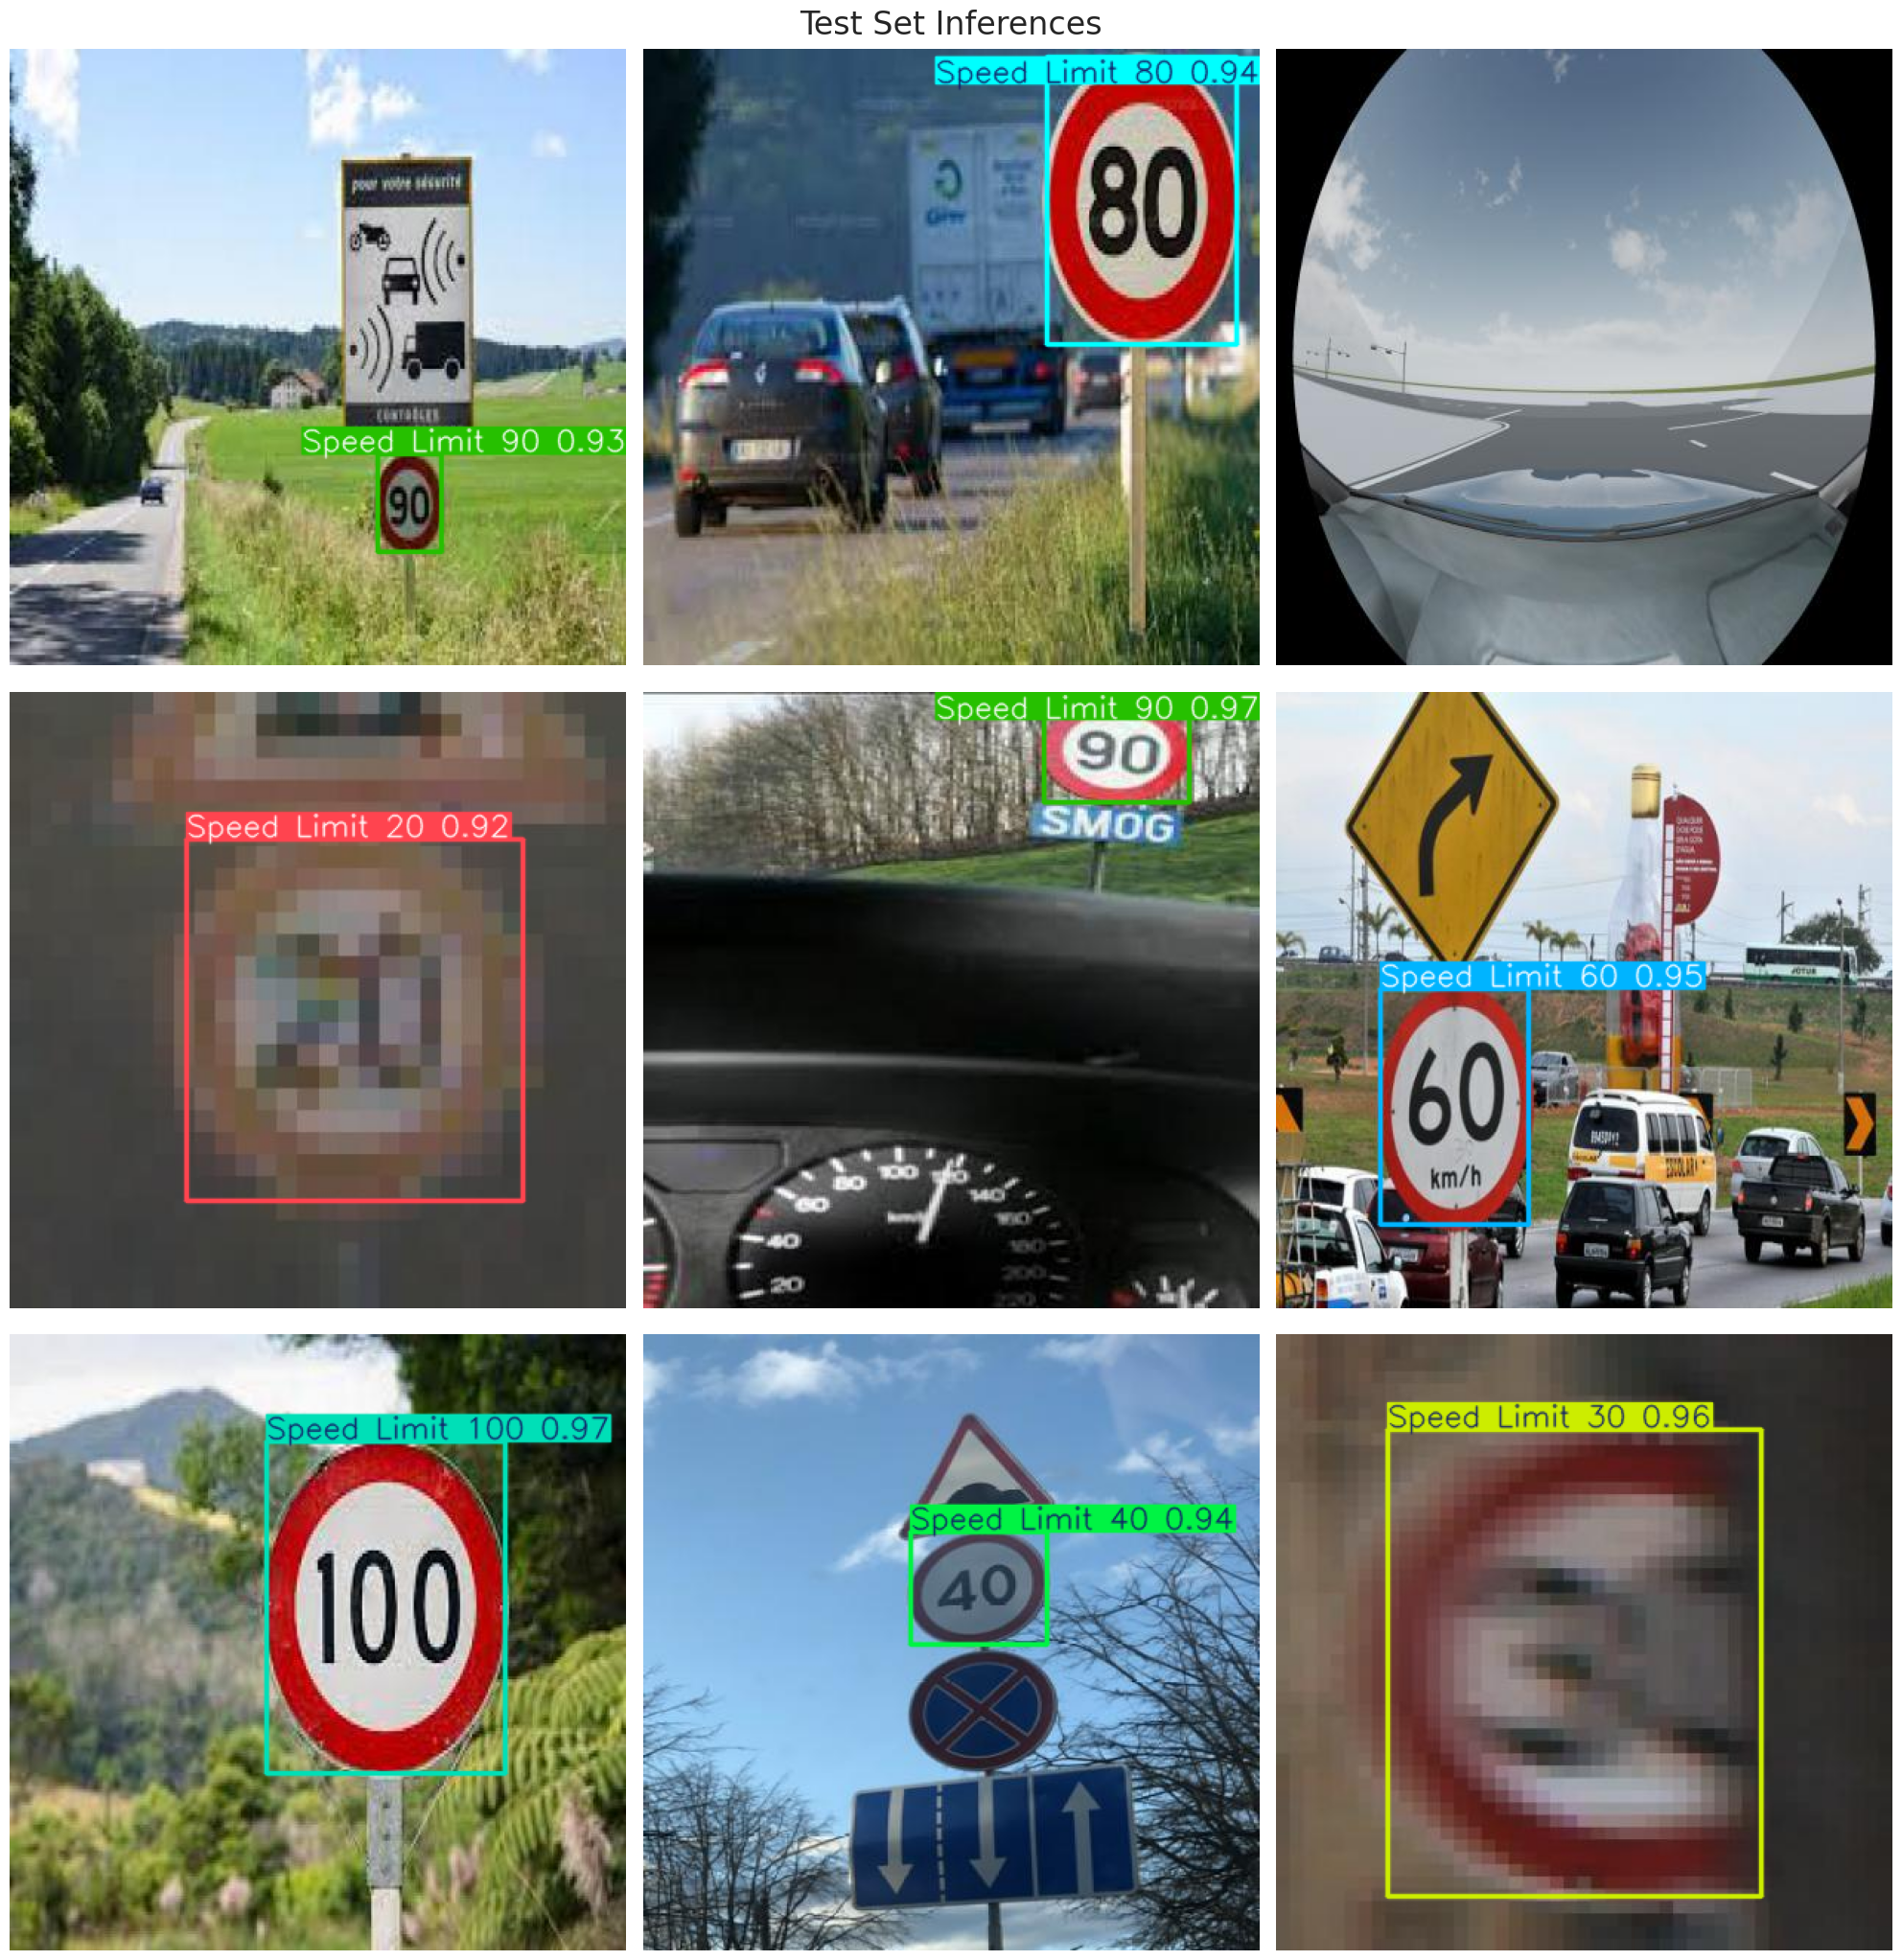

In [ ]:
test_images_dir = os.path.join(dataset_root, 'test', 'images')

if os.path.exists(test_images_dir):
    test_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if test_files:
        # Select a few random images
        num_test_samples = 9
        selected_test_files = random.sample(test_files, min(len(test_files), num_test_samples))

        fig, axes = plt.subplots(3, 3, figsize=(20, 21))
        fig.suptitle('Test Set Inferences', fontsize=24)

        for i, ax in enumerate(axes.flatten()):
            if i < len(selected_test_files):
                image_path = os.path.join(test_images_dir, selected_test_files[i])

                #Predict
                #Ensure best_model is loaded
                if 'best_model' in locals():
                    results = best_model.predict(source=image_path, imgsz=640, conf=0.5)

                    #Plot
                    annotated_image = results[0].plot(line_width=2)
                    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
                    ax.imshow(annotated_image_rgb)
                else:
                    ax.text(0.5, 0.5, 'Model not loaded', ha='center')
            ax.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("No images found in test directory.")
else:
    print(f"Test directory not found: {test_images_dir}")

## 9. Export Trained Model

In [ ]:
if 'best_model' in locals():
    # Export the model
    best_model.export(format='onnx')
    print("Model exported to ONNX format.")
else:
    print("Model not loaded.")

Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs/detect/train3/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 19, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 206ms
Prepared 6 packages in 9.96s
Installed 6 packages in 258ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.74

requirements: AutoUpdate success ✅ 11.1s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.74...
ONNX: expor